In [ ]:
!pip install liwc
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# **Leer LIWC diccionario - Español**

In [ ]:
import liwc

In [ ]:
liwcPath= r'/content/drive/MyDrive/Experimentación Python Tesis /Diccionarios español/Spanish_LIWC2007_Dictionary.dic'
parse, category_names = liwc.load_token_parser(liwcPath)
print(f'Categorias del diccionario: {category_names}')

Categorias del diccionario: ['Funct', 'TotPron', 'PronPer', 'Yo', 'Nosotro', 'TuUtd', 'ElElla', 'Ellos', 'PronImp', 'Articulo', 'Verbos', 'VerbAux', 'Pasado', 'Present', 'Futuro', 'Adverb', 'Prepos', 'Conjunc', 'Negacio', 'Cuantif', 'Numeros', 'Maldec', 'verbYO', 'verbTU', 'verbNOS', 'verbosEL', 'verbELLOS', 'Subjuntiv', 'VosUtds', 'formal', 'informal', 'verbVos', 'Social', 'Familia', 'Amigos', 'Humanos', 'Afect', 'EmoPos', 'EmoNeg', 'Ansiedad', 'Enfado', 'Triste', 'MecCog', 'Insight', 'Causa', 'Discrep', 'Tentat', 'Certeza', 'Inhib', 'Incl', 'Excl', 'Percept', 'Ver', 'Oir', 'Sentir', 'Biolog', 'Cuerpo', 'Salud', 'Sexual', 'Ingerir', 'Relativ', 'Movim', 'Espacio', 'Tiempo', 'Trabajo', 'Logro', 'Placer', 'Hogar', 'Dinero', 'Relig', 'Muerte', 'Asentir', 'NoFluen', 'Relleno']


# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**ansiedad**:   1



In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
#data_train = data.iloc[:num_docs, :]
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64989 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"3522.0, intenta combatir siéntete indeseable c...",1.0
1,302.0,2.147484e+09,"RT @giraltpablo: Lamentablemente, Ecuador perd...",0.0
2,NaN,NaN,Minitrigos helados ansiosos.,1.0
3,NaN,NaN,Está bien. Yo he estado ahí antes. Dudaba de m...,1.0
4,NaN,NaN,¡Siento escuchar eso! Considere la posibilidad...,1.0
5,480.0,2.147484e+09,"No entiendo eso de apoyar en una final,al equi...",0.0
6,266.0,2.147484e+09,"""Come On"" - @akapellah feat @BigSotoLuc &amp; ...",0.0
7,NaN,NaN,",Hola, chico, aparentemente tiene una enfermed...",1.0
8,390.0,2.147484e+09,"RT @excelentum: El que domina su cólera, domin...",0.0
9,288.0,2.147484e+09,RT @Guillodibujante: https://t.co/YO0oAArJJq,0.0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0


In [ ]:
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)
data_train.info()

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64989 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


# **limpiar Dataset**

In [ ]:
import re
import string


def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'https', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)
    text = re.sub(r'[^\w\s]+', '', text)
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                  '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                  ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')
    return text


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : clean(x))

**Remover Stopword**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def Stopword(text):
  token_text = nltk.word_tokenize(text)
  remover_palab = [word for word in token_text if word not in stopwords_en]
  join_text = ' '.join(remover_palab)
  return join_text

In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : Stopword(x))

**Lemmatización**

In [ ]:
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Me gustan los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gustar', 'gato', 'saltar', 'valla']


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : extractTerms(x))

# **Usar LIWC para extraer las caracteristicas del texto**

In [ ]:
corpus = []
words = []

for i in range(0,len(data_train)):
    review = re.sub('[^a-zA-Z0-9]',' ',data_train['TWEET_TEXT'][i])
    review = review.lower()
    review = review.split()

    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)


# **Metodo TfidfVectorizer**

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer=TfidfVectorizer(max_features=5000)
# X_fit=vectorizer.fit(corpus)
# X_transformed=X_fit.transform(corpus)
# features = vectorizer.get_feature_names_out()
# df_count = pd.DataFrame(X_transformed.toarray(),columns = features)
# df_count

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear una instancia de CountVectorizer
count_vect = CountVectorizer()

# Aplicar CountVectorizer al corpus
count_train = count_vect.fit_transform(corpus)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es: ", len(count_vect.vocabulary_))

X = count_train  # Matriz de conteo
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

features = count_vect.get_feature_names_out()

# Crear un DataFrame con la matriz de conteo
df_count = pd.DataFrame(count_train.toarray(), columns=features)
df_count


El tamaño del vocabulario es:  73


,adverb,afect,amigos,ansiedad,articulo,asentir,biolog,causa,certeza,conjunc,...,verbaux,verbellos,verbnos,verbos,verbosel,verbtu,verbvos,verbyo,vosutds,yo
0,0,2,1,0,0,0,1,0,3,1,...,0,0,0,2,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,6,1,0,0,3,3,1,1,0,...,0,1,0,4,0,0,0,0,0,0
4,0,3,0,1,0,0,2,0,1,1,...,0,0,0,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64984,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64985,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
64986,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
64987,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(X.shape)
print(y.shape)

(64989, 73)
(64989,)


# **Dividir los datos de entrenamiento y prueba**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Convertir la matriz TF-IDF a una matriz densa de Numpy
X = X.toarray()

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
# Verificar las dimensiones de los conjuntos de entrenamiento y validación
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (48741, 73)
Dimensiones de X_val: (16248, 73)
Dimensiones de y_train: (48741,)
Dimensiones de y_val: (16248,)


#**Aprendizaje del modelo: Red Neuronal simple**

In [ ]:

# Crear una red neuronal secuencial
model_R = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model_R.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model_R.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model_R.add(Dense(64, activation='relu'))
model_R.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model_R.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_R.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model_R.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model_R.predict(X_val) > 0.5).astype(int)

# Encontrar índices de NaN en y_train
nan_indices = np.isnan(y_train)

# Remover las filas correspondientes en X_train y y_train
X_train = X_train[~nan_indices]
y_train = y_train[~nan_indices]

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model_R.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
# Guardar el modelo entrenado
model_R.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro /modelo_entrenado_BoW_RN.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro /modelo_entrenado_BoW_RN.h5')

Epoch 1/10
1524/1524 [==============================] - 6s 3ms/step - loss: 0.3799 - accuracy: 0.8349 - val_loss: 0.3435 - val_accuracy: 0.8522
Epoch 2/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.3386 - accuracy: 0.8568 - val_loss: 0.3264 - val_accuracy: 0.8649
Epoch 3/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.3228 - accuracy: 0.8643 - val_loss: 0.3209 - val_accuracy: 0.8628
Epoch 4/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.3123 - accuracy: 0.8704 - val_loss: 0.3149 - val_accuracy: 0.8700
Epoch 5/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.3045 - accuracy: 0.8745 - val_loss: 0.3082 - val_accuracy: 0.8724
Epoch 6/10
1524/1524 [==============================] - 5s 4ms/step - loss: 0.2964 - accuracy: 0.8786 - val_loss: 0.3088 - val_accuracy: 0.8726
Epoch 7/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.2886 - accuracy: 0.8820 - val_loss: 0.3168 - val_accuracy:

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 90.0%
Precisión (entrenamiento): 94.0%
Recall (entrenamiento): 86.0%
F1-score (entrenamiento): 90.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 88.0%
Precisión en el conjunto de validación: 91.0%
Recall en el conjunto de validación: 84.0%
F1-score en el conjunto de validación: 87.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_R.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

508/508 [==============================] - 1s 2ms/step
Matriz de confusión: 

 [[7535  677]
 [1319 6717]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.46


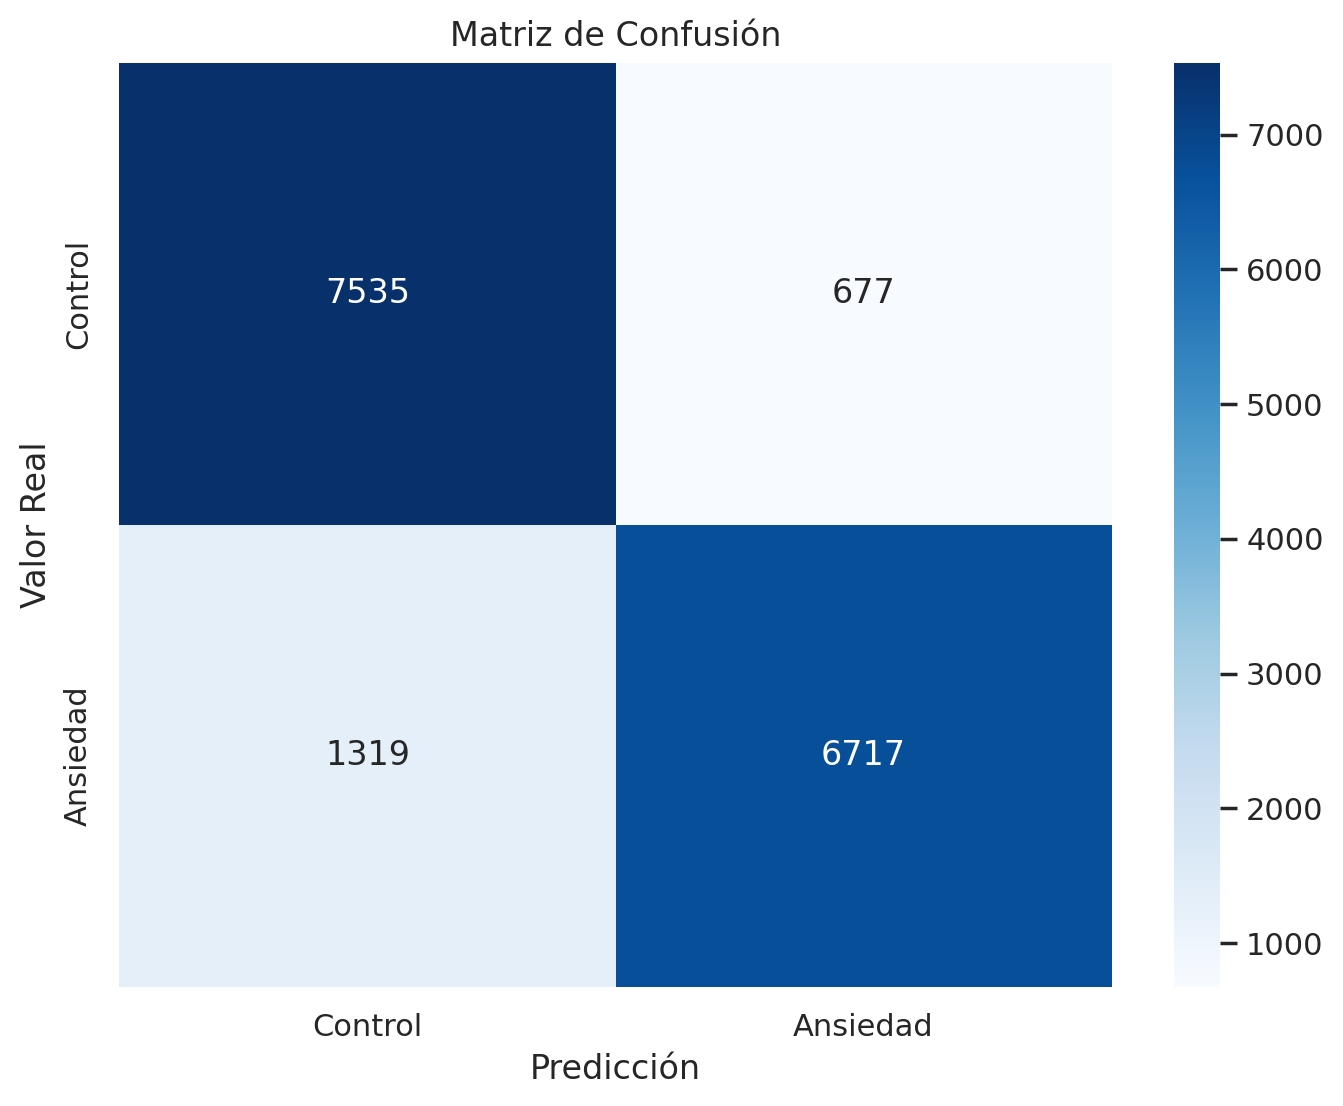

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Entrenamiento con validación cruzada k=10

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train, y_train):
    X_train_index, X_val_index = X_train[train_index], X_train[val_index]
    y_train_index, y_val_index = y[train_index], y[val_index]

   # Comprobar valores NaN en y_train_index
    nan_indices_train = np.isnan(y_train_index)
    if np.any(nan_indices_train):
        X_train_index = X_train_index[~nan_indices_train]
        y_train_index = y_train_index[~nan_indices_train]

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = (model.predict(X_train_index) > 0.5).astype(int)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_index, y_train_pred))
    train_precision_scores.append(precision_score(y_train_index, y_train_pred))
    train_recall_scores.append(recall_score(y_train_index, y_train_pred))
    train_f1_scores.append(f1_score(y_train_index, y_train_pred))

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

# Listas para almacenar métricas de validación
val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train, y_train):
    X_train_index, X_val_index = X_train[train_index], X_train[val_index]
    y_train_index, y_val_index = y_train[train_index], y_train[val_index]

     # Comprobar valores NaN en y_val_index
    nan_indices_val = np.isnan(y_val_index)
    if np.any(nan_indices_val):
        X_val_index = X_val_index[~nan_indices_val]
        y_val_index = y_val_index[~nan_indices_val]

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = (model.predict(X_val_index) > 0.5).astype(int)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_index, y_val_pred))
    val_precision_scores.append(precision_score(y_val_index, y_val_pred))
    val_recall_scores.append(recall_score(y_val_index, y_val_pred))
    val_f1_scores.append(f1_score(y_val_index, y_val_pred))

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

# Guardar el modelo entrenado
model_R.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro /modelo_entrenado_BoW_RN(K=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro /modelo_entrenado_BoW_RN(K=10).h5')

In [ ]:
# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))
print('-----------------------------------------------------------------------')
# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

Entrenamiento - Accuracy: 70.05%
Entrenamiento - Precision: 68.40%
Entrenamiento - Recall: 74.06%
Entrenamiento - F1 Score: 71.08%
-----------------------------------------------------------------------
Validación - Accuracy: 90.20%
Validación - Precision: 92.59%
Validación - Recall: 87.41%
Validación - F1 Score: 89.92%


In [ ]:
from sklearn.metrics import confusion_matrix
with tf.device('/device:CPU:0'):
  y_pred = model.predict(X_val_index)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_index, y_pred_binario)
prop_real = np.sum(y_val_index)/len(y_val_index)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_index)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

153/153 [==============================] - 0s 2ms/step
Matriz de confusión: 

 [[2309  122]
 [ 226 2216]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.48


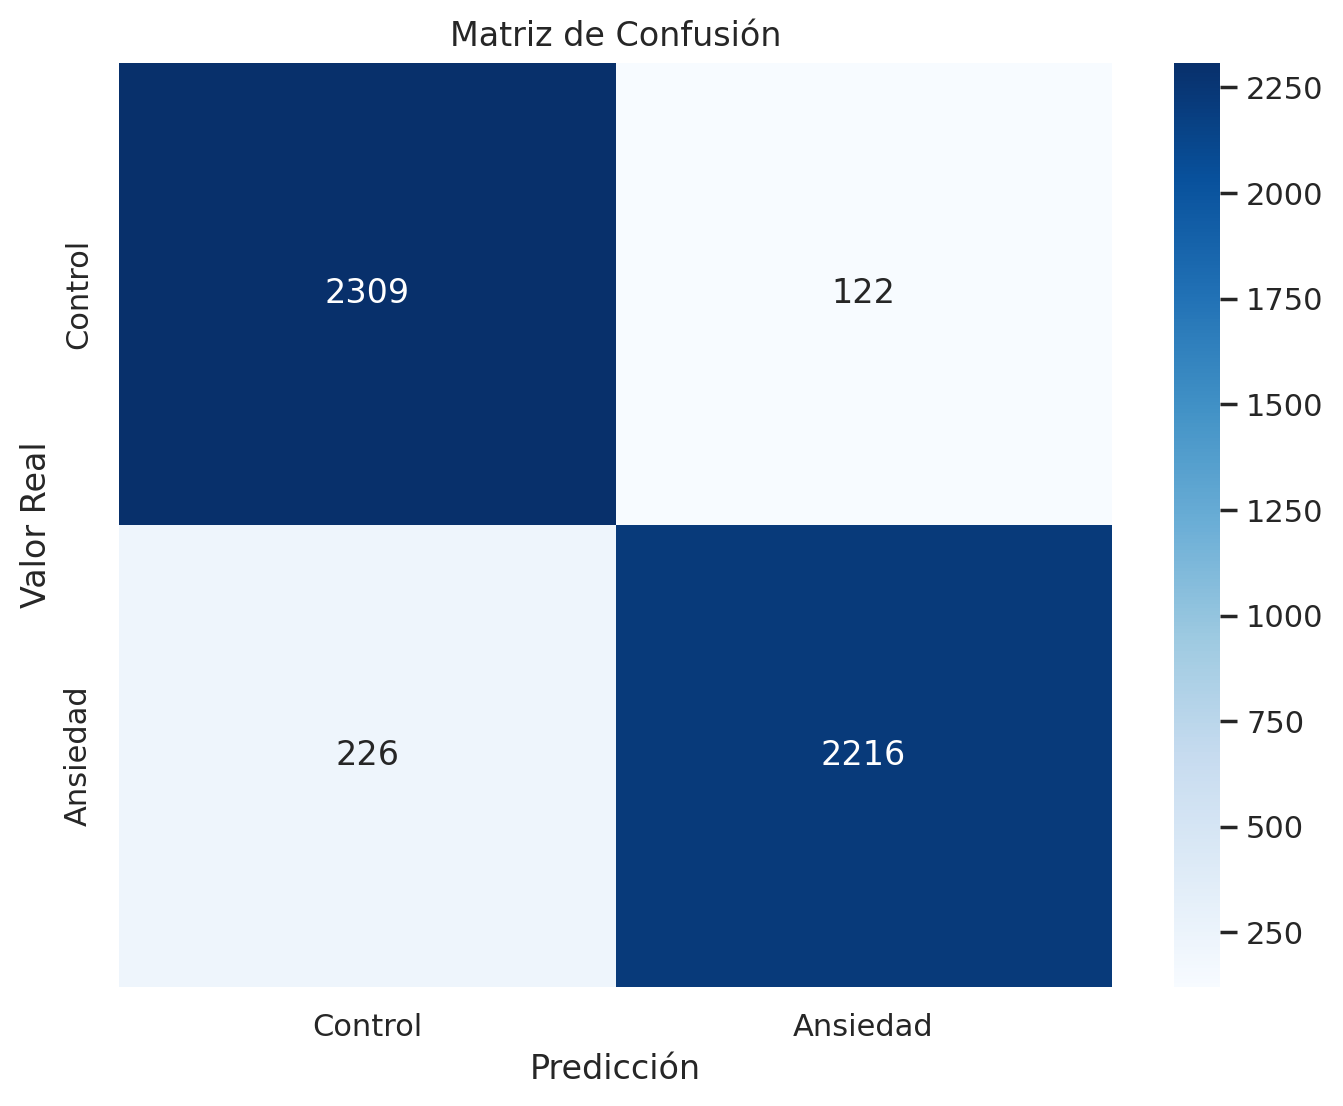

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro '
model_filename = 'TWEETS_ansiedad BoW (RN-CV=10).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LIWC/parametro /TWEETS_ansiedad BoW (RN-CV=10).pkl']